### No Intensity

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from wasserstein import wasserstein_loss
from wasserstein_hist_match import wasserstein_match

def summarize_in_subplot(axs, col, img, hist, gt, gt_hist, cost_mat, title):
    axs[0, col].set_title(title, fontsize=24)
    axs[0, col].imshow(img, vmin=0., vmax=10.)
    axs[1, col].bar(range(len(hist)), hist)
    rmse = np.mean((gt - img)**2)
    wass, T = wasserstein_loss(hist/np.sum(hist),
                               gt_hist/np.sum(gt_hist),
                               cost_mat, eps_abs=1e-10)
    axs[1,col].set_xlabel("RMSE = {:1.3f}, WASS = {:1.3f}".format(rmse, wass), fontsize=24)

class SID:
    """
    Implements Spacing-Increasing Discretization as described in the DORN paper.

    Discretizes the region [alpha, beta]
    Offset controls spacing even further by discretizing [alpha + offset, beta + offset] and then
    subtracting offset from all bin edges.

    Bonus: Includes support for when the index is -1 (in which case the value should be alpha)
    and when it is sid_bins (in which case the value should be beta).

    Works in numpy.
    """
    def __init__(self, sid_bins, alpha, beta, offset):
        self.sid_bins = sid_bins
        self.alpha = alpha
        self.beta = beta
        self.offset = offset

        # Derived quantities
        self.alpha_star = self.alpha + offset
        self.beta_star = self.beta + offset
        bin_edges = np.array(range(sid_bins + 1)).astype(np.float32)
        self.sid_bin_edges = np.array(np.exp(np.log(self.alpha_star) +
                                             bin_edges / self.sid_bins * np.log(self.beta_star / self.alpha_star)))
        self.sid_bin_values = (self.sid_bin_edges[:-1] + self.sid_bin_edges[1:]) / 2 - self.offset
        self.sid_bin_values = np.append(self.sid_bin_values, [self.alpha, self.beta])
        # Do the above so that:
        # self.sid_bin_values[-1] = self.alpha < self.sid_bin_values[0]
        # and
        # self.sid_bin_values[sid_bins] = self.beta > self.sid_bin_values[sid_bins-1]

    def get_sid_index_from_value(self, arr):
        """
        Given an array of values in the range [alpha, beta], return the
        indices of the bins they correspond to
        :param arr: The array to turn into indices.
        :return: The array of indices.
        """
        sid_index = np.floor(self.sid_bins * (np.log(arr + self.offset) - np.log(self.alpha_star)) /
                                             (np.log(self.beta_star) - np.log(self.alpha_star))).astype(np.int32)
        sid_index = np.clip(sid_index, a_min=-1, a_max=self.sid_bins)
        # An index of -1 indicates alpha, while self.sid_bins indicates beta
        return sid_index

    def get_value_from_sid_index(self, sid_index):
        """
        Given an array of indices in the range {-1, 0,...,sid_bins},
        return the representative value of the selected bin.
        :param sid_index: The array of indices.
        :return: The array of values correspondding to those indices
        """
        return np.take(self.sid_bin_values, sid_index)

    def __repr__(self):
        return repr((self.sid_bins, self.alpha, self.beta, self.offset))

In [8]:
# Load actual depth image
from matplotlib._png import read_png
orig = read_png("data/4597_depth.png")
orig = (orig - np.min(orig))/(np.max(orig) - np.min(orig))
new_max = 2
new_min = 0.8
sid_obj = SID(sid_bins=68, alpha=0.6569154266167957, beta=9.972175646365525, offset=0)

# Cost matrix
cost_mat = np.array([[(p - q)**2 for p in sid_obj.sid_bin_values[:-2]]
                                 for q in sid_obj.sid_bin_values[:-2]
                    ]
                   )

# Make ground truth
gt = orig * new_max + new_min
gt_index = sid_obj.get_sid_index_from_value(gt)
gt_hist, _ = np.histogram(gt_index, bins=range(sid_obj.sid_bins + 1))

# sh = shifted
# Make shifted image
sh = gt + 1.
# shifted = gt*1.3
sh_index = sid_obj.get_sid_index_from_value(sh)
sh_hist, _ = np.histogram(sh_index, bins=range(sid_obj.sid_bins + 1))

In [9]:
# Load RGB image
albedo = read_png("data/4597_albedo.png")

# Make Intensity-scaled hist
intensity = 0.2989 * albedo[..., 0] + 0.5870 * albedo[..., 1] + 0.1140 * albedo[..., 2]
sh_int_hist, _ = np.histogram(sh_index, weights=intensity,
                              bins=range(sid_obj.sid_bins+1))
gt_int_hist, _ = np.histogram(gt_index, weights=intensity,
                              bins=range(sid_obj.sid_bins+1))

In [10]:
sh_pred_index, sh_pred, sh_pred_hist = \
    wasserstein_match(sh_index, gt_hist, cost_mat, weights=np.ones_like(sh_index), sid_obj=sid_obj)

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 4624, constraints m = 4760
          nnz(P) + nnz(A) = 13872
settings: linear system solver = qdldl,
          eps_abs = 1.0e-10, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1  -1.4946e+05   6.75e+00   1.67e+03   1.00e-01   8.93e-03s
 200   1.0085e+00   3.89e-04   8.36e-02   2.13e+00   3.40e-02s
 400   1.0094e+00   6.50e-05   8.62e-03   2.13e+00   5.95e

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 4624, constraints m = 4760
          nnz(P) + nnz(A) = 13872
settings: linear system solver = qdldl,
          eps_abs = 1.0e-10, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1  -1.4946e+05   6.75e+00   1.22e+03   1.00e-01   7.69e-03s
 200   1.5496e-02   3.73e-05   3.92e-02   3.33e+00   2.94e-02s
 400   1.2253e-02   3.28e-05   6.51e-03   3.33e+00   5.33e

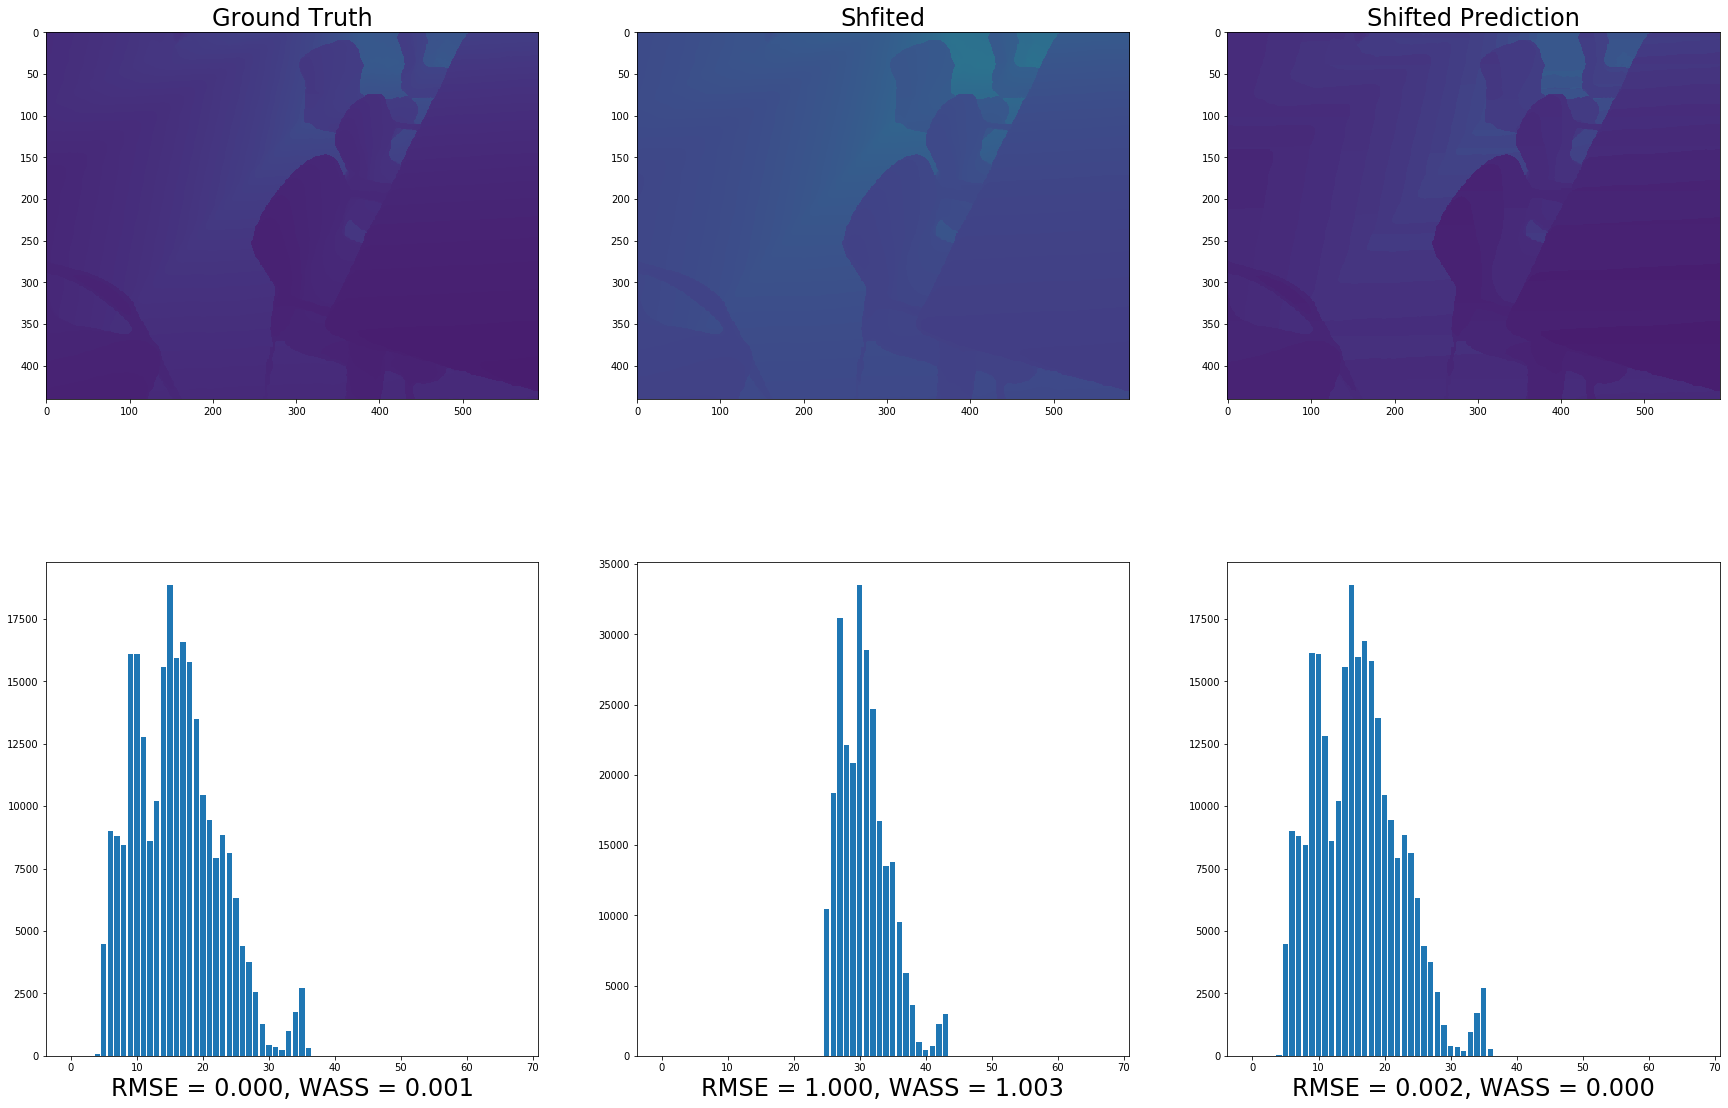

In [11]:
# Display
### Ground Truth
fig, axs = plt.subplots(2, 3, figsize=(30, 20))
fontsize=24

summarize_in_subplot(axs, 0, img=gt, hist=gt_hist, gt=gt, gt_hist=gt_hist, 
                     cost_mat=cost_mat, title="Ground Truth")
summarize_in_subplot(axs, 1, img=sh, hist=sh_hist, gt=gt, gt_hist=gt_hist,
                     cost_mat=cost_mat, title="Shfited")
summarize_in_subplot(axs, 2, img=sh_pred, hist=sh_pred_hist, gt=gt, gt_hist=gt_hist,
                     cost_mat=cost_mat, title="Shifted Prediction")

### With Intensity

In [12]:
sh_int_pred_index, sh_int_pred, sh_int_pred_hist = \
    wasserstein_match(sh_index, gt_int_hist, cost_mat, intensity, sid_obj)

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 4624, constraints m = 4760
          nnz(P) + nnz(A) = 13872
settings: linear system solver = qdldl,
          eps_abs = 1.0e-10, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1  -1.4946e+05   6.75e+00   1.69e+03   1.00e-01   9.64e-03s
 200   1.0020e+00   2.91e-04   4.11e-02   2.06e+00   3.42e-02s
 400   1.0083e+00   4.90e-05   9.30e-03   2.06e+00   6.04e

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 4624, constraints m = 4760
          nnz(P) + nnz(A) = 13872
settings: linear system solver = qdldl,
          eps_abs = 1.0e-10, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1  -1.4946e+05   6.75e+00   1.14e+03   1.00e-01   7.78e-03s
 200   1.6766e-02   7.54e-05   3.10e-02   3.58e+00   2.86e-02s
 400   7.3451e-03   1.91e-05   6.90e-03   3.58e+00   5.32e

1800   1.8933e-03   3.29e-06   2.68e-03   3.58e+00   2.17e-01s
2000   1.8764e-03   3.29e-06   2.40e-03   3.58e+00   2.39e-01s
2200   1.8179e-03   3.29e-06   2.20e-03   3.58e+00   2.65e-01s
2400   1.7453e-03   3.29e-06   2.27e-03   3.58e+00   2.89e-01s
2600   1.7066e-03   3.29e-06   2.26e-03   3.58e+00   3.15e-01s
2800   1.6175e-03   3.29e-06   2.06e-03   3.58e+00   3.40e-01s
3000   1.6247e-03   3.29e-06   2.06e-03   3.58e+00   3.67e-01s
3200   1.5817e-03   3.29e-06   2.06e-03   3.58e+00   3.90e-01s
3400   5.9842e-04   3.18e-06   1.93e-03   3.58e+00   4.13e-01s
3600   6.9734e-04   3.18e-06   1.80e-03   3.58e+00   4.36e-01s
3800   6.8715e-04   3.18e-06   1.70e-03   3.58e+00   4.59e-01s
4000   5.8811e-04   3.18e-06   1.75e-03   3.58e+00   4.85e-01s
4200   4.6349e-04   3.19e-06   1.23e-03   3.58e+00   5.08e-01s
4400   5.1294e-04   3.19e-06   1.20e-03   3.58e+00   5.31e-01s
4600   3.7867e-04   2.51e-06   1.24e-03   3.58e+00   5.54e-01s
4800   1.3652e-04   2.28e-07   1.21e-03   3.58e+00   5.

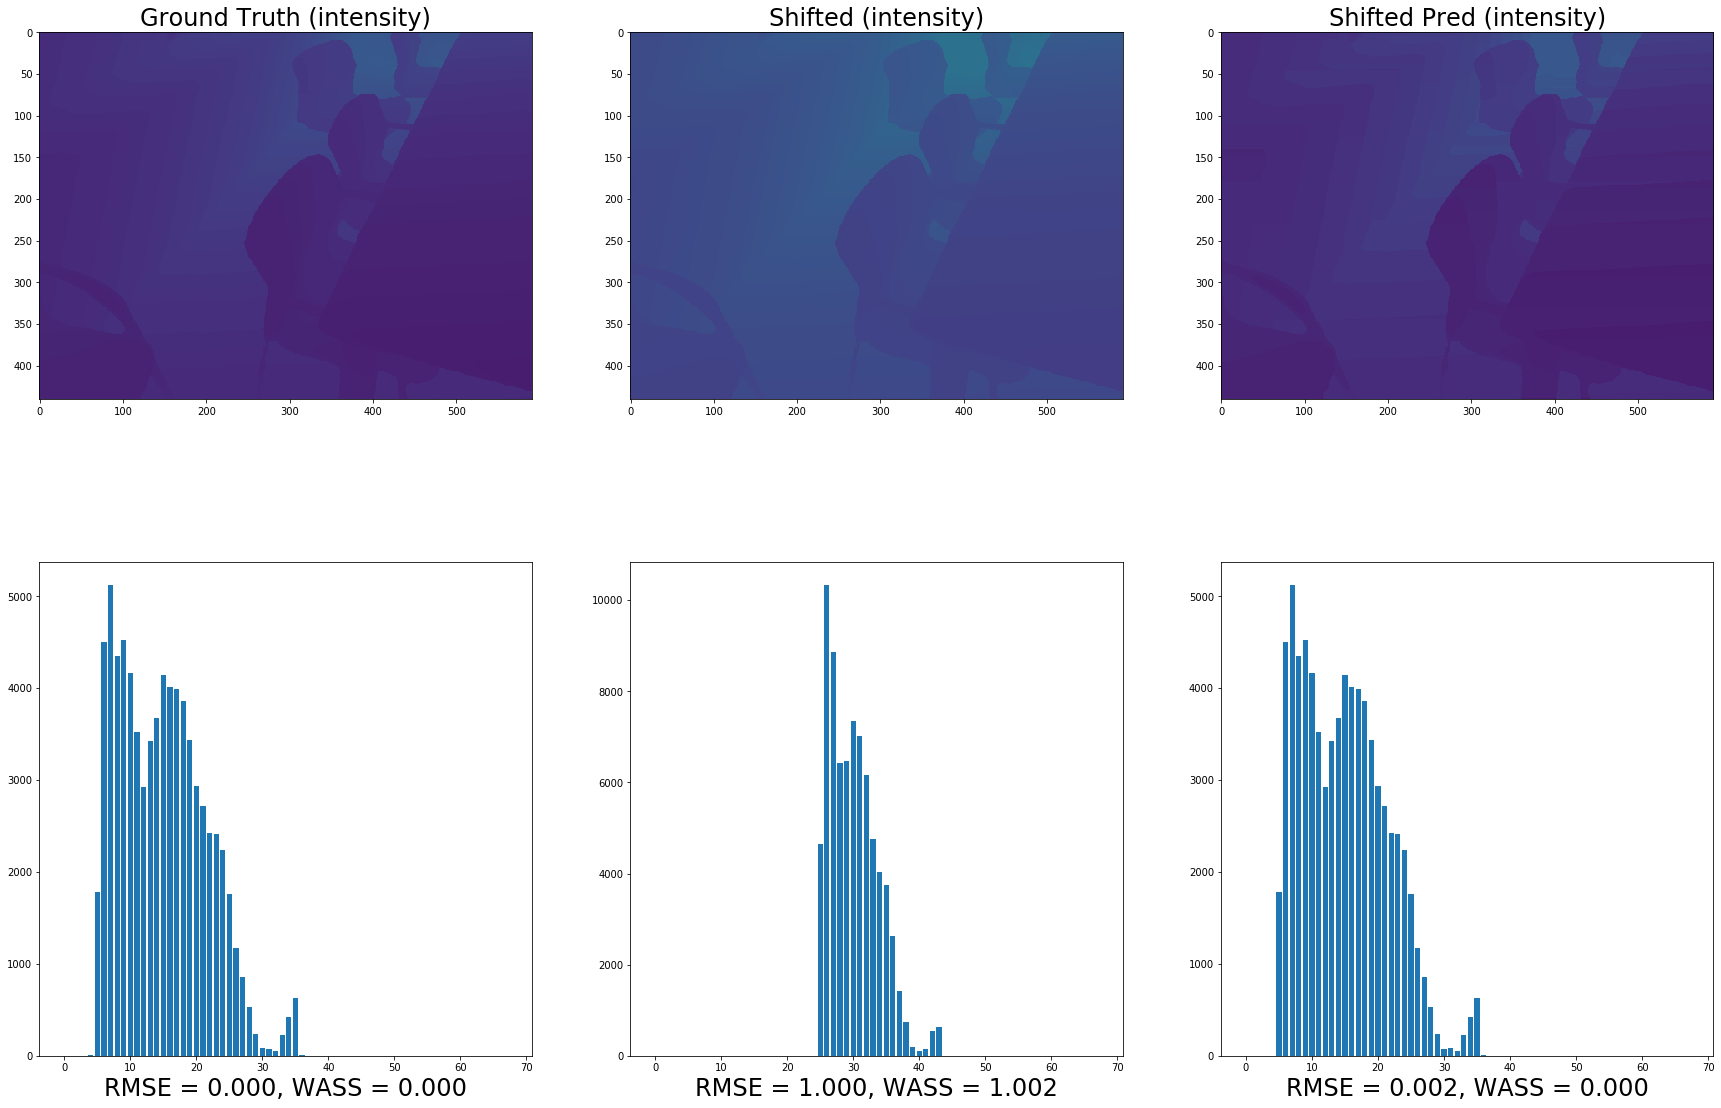

In [13]:
### Display
fig, axs = plt.subplots(2, 3, figsize=(30, 20))
summarize_in_subplot(axs, 0, img=gt, hist=gt_int_hist, gt=gt, gt_hist=gt_int_hist,
                     cost_mat=cost_mat, title="Ground Truth (intensity)")
summarize_in_subplot(axs, 1, img=sh, hist=sh_int_hist, gt=gt, gt_hist=gt_int_hist,
                     cost_mat=cost_mat, title="Shifted (intensity)")
summarize_in_subplot(axs, 2, img=sh_int_pred, hist=sh_int_pred_hist, gt=gt, gt_hist=gt_int_hist,
                     cost_mat=cost_mat, title="Shifted Pred (intensity)")